# Derivas de concepto en la mempool. Método ADWIN

Detección de derivas de concepto en la media de transacciones de la mempool por intervalo de tiempo, a partir del método matemático ADWIN, con salida gráfica.

In [1]:
!pip install river

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from btc_connect import btc_connect
from bitcoinrpc.authproxy import JSONRPCException
from river import drift
from datetime import datetime
import time, numpy as np, matplotlib.pyplot as plt

In [3]:
# Conección al nodo local
rpc_connection = btc_connect()

In [4]:
# Adaptación de función para graficar el total de transacciones de la mempool y las derivas de concepto detectadas
# https://riverml.xyz/latest/introduction/getting-started/concept-drift-detection/
def plot_transaction(x, y, xlabel, drift=None):
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(x, y, label="transacciones")
    ax.set_ylim(bottom=0)
    ax.set_title("Número de transacciones pendientes")
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Transacciones")
    if drift is not None:
        legend=0
        for drift_detected in drift:
            if legend==0:
                ax.axvline(drift_detected, color="red", linestyle=":", label="derivas de concepto")
                legend=1
            else:
                ax.axvline(drift_detected, color="red", linestyle=":")
    fig.legend(loc="outside upper left")
    plt.show()

In [5]:
mempool_temp_transactions = []
mempool_iteration = []
mempool_datetime = []
mempool_transactions = []

# ADWIN Valores por defecto:
# https://riverml.xyz/dev/api/drift/ADWIN/
# delta=0.002         -> Valor de significancia 
# clock=32            -> Frecuencia con la que se comprueban cambios. 1 => con cada nuevo dato
# max_buckets=5       -> Cantidad máxima de contenedores de datos de cada tamaño que se debe mantener, como paso previo a ser fusionados
# min_window_length=5 -> Longitud mínima que debe tener una subventana para ser evaluada 
# grace_period=10     -> Cantidad mínima de datos exigida para realizar la detección de cambios

drift_detector = drift.ADWIN(delta=0.000002)

mempool_iteration_drift = [] # Iteración en la que se detecta una deriva de concepto en la mempool
mempool_datetime_drift = []  # Instante temporal en el que se detecta una deriva de concepto en la mempool
mempool_transactions_drift = []  # Número total de transacciones que activa una deriva

start=""
i = 0

observations = 60
repetitions = 1440  # 24 horas
seconds = 1

while i < repetitions:
    j = 0
    mempool_temp_transactions.clear()
    while j < observations:
        try:
            # Obtiente la mempool del nodo local
            mempool = rpc_connection.getmempoolinfo()
        except JSONRPCException as e:
            print(f"Error al obtener la mempool del nodo local: {e}")
            mempool = {}
    
        timestamp = datetime.now().strftime('%d/%m/%Y %H:%M:%S')
        if start == "":
            start = timestamp
    
        mempool_temp_transactions.append(mempool["size"])            
        j+=1
        # Tiempo para realizar la siguiente solicitud
        time.sleep(seconds)
    
    mempool_iteration.append(i)
    mempool_datetime.append(timestamp)
    mempool_mean = np.mean(mempool_temp_transactions)
    mempool_transactions.append(mempool_mean)
    #print(mempool_mean)
    
    drift_detector.update(mempool_mean)
    if drift_detector.drift_detected:  # Deriva de concepto detectada
        mempool_iteration_drift.append(i)
        mempool_datetime_drift.append(timestamp)
        mempool_transactions_drift.append(mempool_mean)
    i+=1
   
end = timestamp
xlabel = f"Inicio: {start} - Fin: {end}. Número de iteraciones: {i}"

### Derivas de concepto detectadas

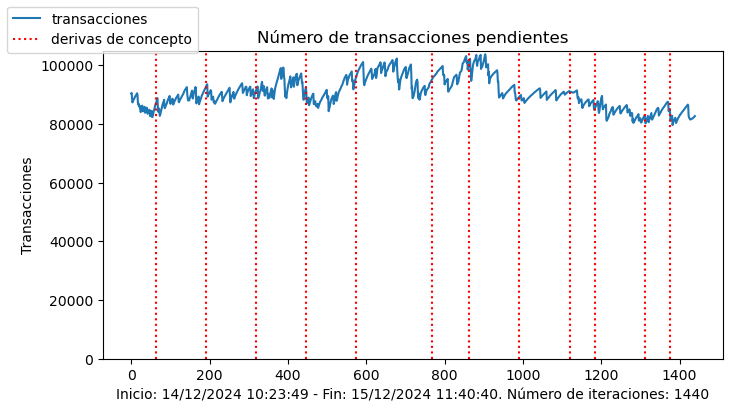

In [6]:
plot_transaction(mempool_iteration, mempool_transactions, xlabel, mempool_iteration_drift)

In [7]:
print(mempool_iteration)
print(mempool_transactions)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

### Instante temporal en el que se detecta una deriva de concepto y número de transacciones

In [8]:
for x, y in (zip(mempool_datetime_drift, mempool_transactions_drift)):
    print(f"Instante temporal {x}: {y} transacciones")

Instante temporal 14/12/2024 11:37:44: 87105.75 transacciones
Instante temporal 14/12/2024 14:15:15: 92849.05 transacciones
Instante temporal 14/12/2024 16:28:09: 91590.08333333333 transacciones
Instante temporal 14/12/2024 18:40:37: 91034.8 transacciones
Instante temporal 14/12/2024 20:50:39: 96281.03333333334 transacciones
Instante temporal 15/12/2024 00:07:17: 95034.58333333333 transacciones
Instante temporal 15/12/2024 01:44:49: 100952.56666666667 transacciones
Instante temporal 15/12/2024 03:54:14: 89356.23333333334 transacciones
Instante temporal 15/12/2024 06:05:18: 91231.96666666666 transacciones
Instante temporal 15/12/2024 07:14:56: 85209.41666666667 transacciones
Instante temporal 15/12/2024 09:27:05: 82951.61666666667 transacciones
Instante temporal 15/12/2024 10:33:49: 84851.01666666666 transacciones
